# Add Label For Prediction
基于 Marcos López de Prado《Advances in Financial Machine Learning》的方法：
1. **动态波动率估计** — 使用指数加权移动标准差 (EWMA) 估计每根bar的波动率
2. **CUSUM Filter** — 基于累积偏差过滤事件触发点，只在显著价格变动时打标签
3. **Triple Barrier Labeling** — 在 CUSUM 触发点应用三重屏障标注法：
   - 上屏障 (profit-taking): 价格触及 `close * (1 + pt_sl[0] * σ)`
   - 下屏障 (stop-loss): 价格触及 `close * (1 - pt_sl[1] * σ)`
   - 竖直屏障 (max holding period): 持有 `num_bars` 根 bar 后强制平仓
4. **Meta-labeling 支持** — 生成 `{-1, 0, 1}` 标签或连续收益率标签

### 1. 导入必要的库

In [4]:
# 1. Import dependencies and load data
from pathlib import Path
import numpy as np
import pandas as pd
import numba
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from src.utils.logger import logger

# Configure plotting style
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (14, 6)
plt.rcParams['font.sans-serif'] = ['DejaVu Sans', 'SimHei']
plt.rcParams['axes.unicode_minus'] = False

# ---- Load data ----
project_root = Path.cwd().parent.parent
data_path = project_root / "data" / "preprocess_data" / "factor" / "BTCUSDT" \
    / "BTCUSDT_2025-01-01_2025-12-31_dollar_bars_4m_with_ffd.csv"

df = pd.read_csv(data_path)

# Parse timestamps (microseconds)
df["datetime"] = pd.to_datetime(df["timestamp"], unit="us")
df = df.set_index("datetime").sort_index()

logger.info(f"Loaded {len(df)} dollar bars | Range: {df.index[0]} → {df.index[-1]}")
logger.info(f"Columns: {list(df.columns)}")
df.head()

| INFO     | __main__:<module>:28 - Loaded 82145 dollar bars | Range: 2025-01-01 00:00:00.010866 → 2025-12-31 23:38:18.734186
| INFO     | __main__:<module>:29 - Columns: ['timestamp', 'open', 'high', 'low', 'close', 'volume', 'dollar_volume', 'num_trades', 'close_time', 'ffd_close']


,timestamp,open,high,low,close,volume,dollar_volume,num_trades,close_time,ffd_close
datetime,,,,,,,,,,
2025-01-01 00:00:00.010866,1735689600010866,93576.00,93702.15,93537.50,93677.98,48.22810,4.516081e+06,3606,1735689942737373,NaN
2025-01-01 00:05:43.095820,1735689943095820,93677.98,93678.02,93600.00,93612.00,48.23934,4.516821e+06,1303,1735690098274250,NaN
2025-01-01 00:08:18.318322,1735690098318322,93612.00,93623.38,93536.52,93544.58,48.28969,4.519979e+06,1175,1735690260293220,NaN
2025-01-01 00:11:00.301941,1735690260301941,93544.58,93810.18,93489.03,93810.17,48.38964,4.529446e+06,3823,1735690652885387,NaN
2025-01-01 00:17:32.885563,1735690652885563,93810.17,93898.05,93794.73,93800.00,48.39496,4.541061e+06,3027,1735690921311686,NaN


### 2. 计算波动率

| INFO     | __main__:<module>:25 - Volatility: mean=0.001447, median=0.001296, min=0.000422, max=0.007213


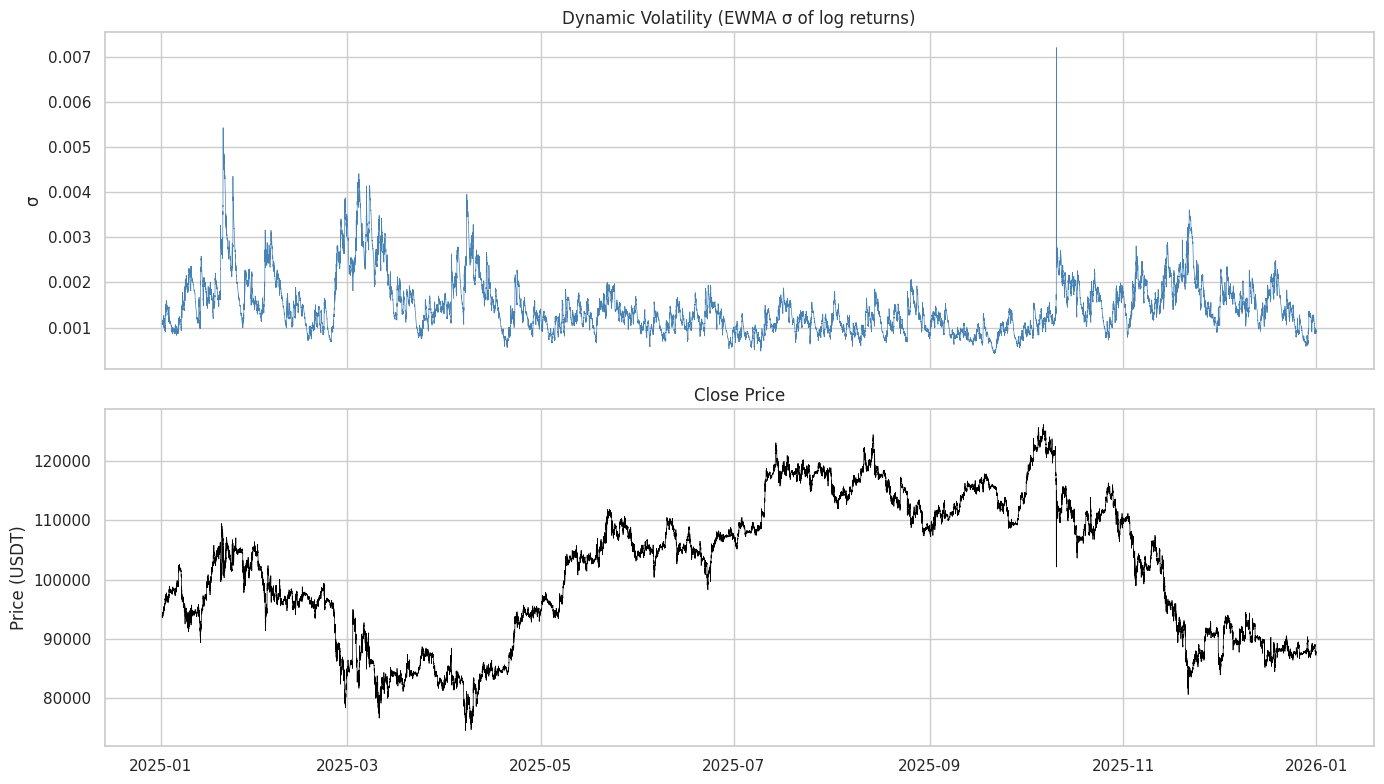

| INFO     | __main__:<module>:40 - Valid volatility points: 82045/82145


In [5]:
# 2. Compute Dynamic Volatility (EWMA Volatility)
# Use exponentially weighted moving standard deviation to estimate intraday volatility
# for dynamically adjusting barrier width

def get_daily_volatility(close: pd.Series, span: int = 100) -> pd.Series:
    """
    Compute dynamic volatility for each bar.
    Uses EWMA standard deviation of log returns as the volatility estimate.
    
    Parameters
    ----------
    close : pd.Series - Close price series
    span  : int       - EWMA window (number of bars)
    
    Returns
    -------
    pd.Series - Volatility series
    """
    log_returns = np.log(close / close.shift(1))
    volatility = log_returns.ewm(span=span, min_periods=span).std()
    return volatility.dropna()

# Compute volatility
vol = get_daily_volatility(df["close"], span=100)
logger.info(f"Volatility: mean={vol.mean():.6f}, median={vol.median():.6f}, "
            f"min={vol.min():.6f}, max={vol.max():.6f}")

# Visualization
fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)
axes[0].plot(vol.index, vol.values, linewidth=0.5, color='steelblue')
axes[0].set_title("Dynamic Volatility (EWMA σ of log returns)")
axes[0].set_ylabel("σ")

axes[1].plot(df["close"].loc[vol.index], linewidth=0.5, color='black')
axes[1].set_title("Close Price")
axes[1].set_ylabel("Price (USDT)")
plt.tight_layout()
plt.show()

logger.info(f"Valid volatility points: {vol.notna().sum()}/{len(df)}")

### 3. CUSUM Filter — 事件驱动采样
CUSUM (Cumulative Sum) Filter 用于检测价格序列的结构性变化，仅在价格累积偏离超过阈值 `h` 时触发事件。
- 避免对所有 bar 打标签（冗余 + 过拟合）
- 阈值 `h` 通常取波动率的均值或中位数

| INFO     | __main__:<module>:34 - CUSUM threshold h = 147.07 USDT
| INFO     | __main__:<module>:38 - CUSUM events: 32564 / 82145 bars (39.6%)


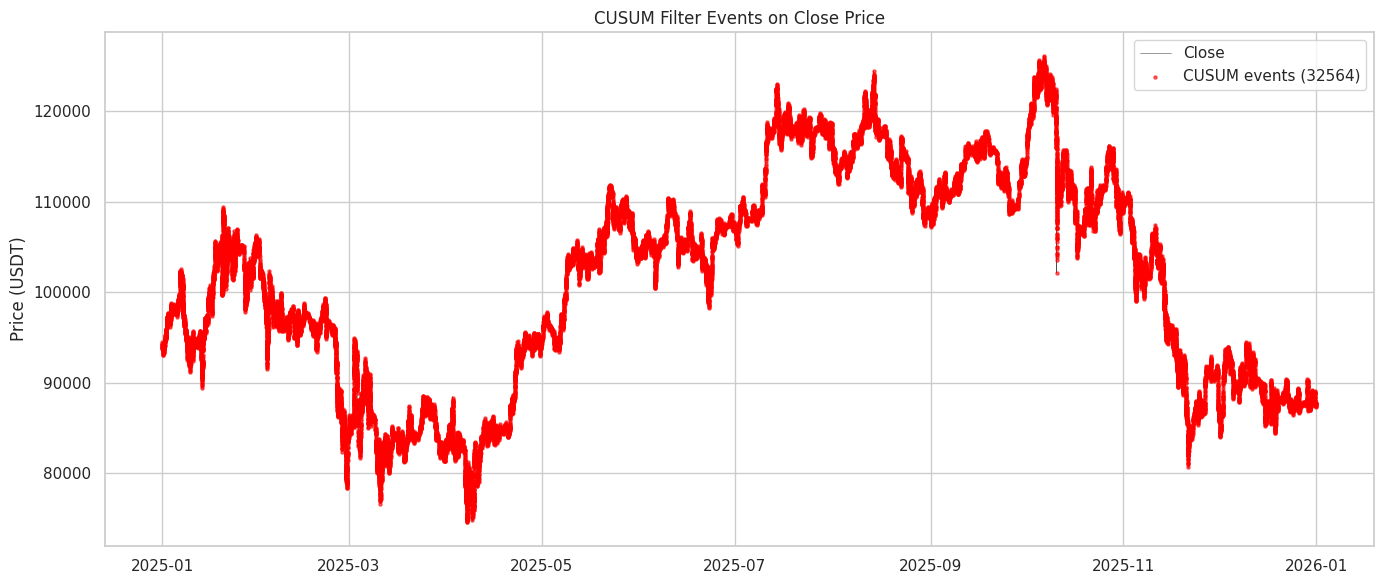

In [7]:
# 3. CUSUM Filter
def cusum_filter(close: pd.Series, h: float) -> pd.DatetimeIndex:
    """
    Symmetric CUSUM Filter — detects cumulative upward and downward deviations.
    
    Parameters
    ----------
    close : pd.Series - Close price series (datetime index)
    h     : float     - Trigger threshold (typically mean/median of volatility)
    
    Returns
    -------
    pd.DatetimeIndex - Event trigger timestamps
    """
    events = []
    s_pos, s_neg = 0.0, 0.0
    diff = close.diff().dropna()
    
    for t, val in diff.items():
        s_pos = max(0.0, s_pos + val)
        s_neg = min(0.0, s_neg + val)
        
        if s_neg < -h:
            s_neg = 0.0
            events.append(t)
        elif s_pos > h:
            s_pos = 0.0
            events.append(t)
    
    return pd.DatetimeIndex(events)

# CUSUM threshold = mean volatility × mean close price (convert log-return σ to price scale)
h = vol.mean() * df["close"].mean()
logger.info(f"CUSUM threshold h = {h:.2f} USDT")

# Run CUSUM Filter
cusum_events = cusum_filter(df["close"], h)
logger.info(f"CUSUM events: {len(cusum_events)} / {len(df)} bars "
            f"({len(cusum_events)/len(df)*100:.1f}%)")

# Visualize CUSUM trigger points
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(df.index, df["close"], linewidth=0.4, color='black', alpha=0.7, label='Close')
# Use deduplicated index to avoid size mismatch from duplicate timestamps
close_dedup = df.loc[~df.index.duplicated(keep='first'), "close"]
valid_events = cusum_events[cusum_events.isin(close_dedup.index)]
ax.scatter(valid_events, close_dedup.loc[valid_events], 
           color='red', s=5, alpha=0.6, zorder=5, label=f'CUSUM events ({len(cusum_events)})')
ax.set_title("CUSUM Filter Events on Close Price")
ax.set_ylabel("Price (USDT)")
ax.legend()
plt.tight_layout()
plt.show()

### 4. Triple Barrier Labeling
对每个 CUSUM 触发点，设置三道屏障：
- **上屏障 (Take Profit)**: `close × (1 + pt_sl[0] × σ)` → 标签 = 1
- **下屏障 (Stop Loss)**: `close × (1 - pt_sl[1] × σ)` → 标签 = -1
- **竖直屏障 (Max Holding)**: 持有 `num_bars` 根 bar 后强制退出 → 标签由收益方向决定

当 `min_ret > 0` 时，竖直屏障处收益率绝对值 < min_ret 将标记为 0

In [14]:
# 4. Triple Barrier Labeling

def _first_loc(idx, t):
    """Resolve get_loc result to a single int (handles duplicate indices)."""
    loc = idx.get_loc(t)
    if isinstance(loc, slice):
        return loc.start
    elif isinstance(loc, np.ndarray):
        return np.flatnonzero(loc)[0]
    return loc


def get_events(close: pd.Series, 
               timestamps: pd.DatetimeIndex,
               vol: pd.Series,
               pt_sl: list = [1.0, 1.0],
               num_bars: int = 50,
               min_ret: float = 0.0) -> pd.DataFrame:
    """
    Build a Triple Barrier event table for each event timestamp.
    
    Parameters
    ----------
    close      : pd.Series        - Close price series
    timestamps : pd.DatetimeIndex  - CUSUM trigger timestamps
    vol        : pd.Series        - Volatility series
    pt_sl      : list [float, float] - Upper/lower barrier width (multiples of σ), 0 disables the barrier
    num_bars   : int              - Vertical barrier (max holding bars)
    min_ret    : float            - Min return threshold, |ret| < min_ret → label=0
    
    Returns
    -------
    pd.DataFrame with columns: [t1, target]
        t1     : Barrier trigger time
        target : Volatility used to set barrier
    """
    # 1. Filter valid events (must have corresponding volatility)
    timestamps = timestamps[timestamps.isin(vol.index)]
    timestamps = timestamps[timestamps.isin(close.index)]
    
    # 2. Build vertical barriers
    # For each event, find the time num_bars bars later
    close_idx = close.index
    vertical_barriers = pd.Series(dtype='datetime64[ns]', index=timestamps)
    for t in timestamps:
        loc = _first_loc(close_idx, t)
        if loc + num_bars < len(close_idx):
            vertical_barriers[t] = close_idx[loc + num_bars]
        else:
            vertical_barriers[t] = close_idx[-1]  # Use the last bar if data is insufficient
    
    # 3. Build event table
    # Use reindex to get exactly one volatility value per timestamp (handles duplicates)
    vol_dedup = vol[~vol.index.duplicated(keep='first')]
    events = pd.DataFrame({
        't1': vertical_barriers,
        'target': vol_dedup.reindex(timestamps).values
    }, index=timestamps)
    events = events.dropna(subset=['target'])
    
    return events


def apply_triple_barrier(close: pd.Series, 
                         events: pd.DataFrame,
                         pt_sl: list = [1.0, 1.0]) -> pd.DataFrame:
    """
    Apply Triple Barrier to each event and determine the first barrier hit.
    
    Parameters
    ----------
    close  : pd.Series    - Close price series
    events : pd.DataFrame - Event table (from get_events)
    pt_sl  : list         - [upper barrier multiplier, lower barrier multiplier]
    
    Returns
    -------
    pd.DataFrame with columns: [t1, pt_time, sl_time, ret, label]
    """
    results = []
    close_idx = close.index
    
    for t0, row in tqdm(events.iterrows(), total=len(events), desc="Applying Triple Barrier"):
        t1 = row['t1']  # Vertical barrier
        target = row['target']  # Volatility
        
        # Upper/lower barrier thresholds (log return)
        pt_level = target * pt_sl[0] if pt_sl[0] > 0 else np.inf
        sl_level = target * pt_sl[1] if pt_sl[1] > 0 else np.inf
        
        # Get price path in [t0, t1] interval
        path = close.loc[t0:t1]
        if len(path) < 2:
            continue
        
        entry_price = close.iloc[_first_loc(close_idx, t0)]
        # Compute log returns
        log_rets = np.log(path / entry_price)
        
        # Find first upper barrier hit
        pt_hits = log_rets[log_rets >= pt_level]
        pt_time = pt_hits.index[0] if len(pt_hits) > 0 else pd.NaT
        
        # Find first lower barrier hit
        sl_hits = log_rets[log_rets <= -sl_level]
        sl_time = sl_hits.index[0] if len(sl_hits) > 0 else pd.NaT
        
        # Determine the first barrier touched
        first_touch = pd.Series({
            'pt': pt_time,
            'sl': sl_time,
            'vb': t1
        }).dropna().sort_values()
        
        if len(first_touch) == 0:
            continue
            
        exit_time = first_touch.iloc[0]
        exit_type = first_touch.index[0]
        
        # Compute actual exit return
        exit_price = close.iloc[_first_loc(close_idx, exit_time)]
        exit_ret = np.log(exit_price / entry_price)
        
        results.append({
            't0': t0,
            't1': exit_time,
            'exit_type': exit_type,  # 'pt', 'sl', 'vb'
            'pt_time': pt_time,
            'sl_time': sl_time,
            'target': target,
            'ret': exit_ret,
            'entry_price': entry_price,
            'exit_price': exit_price,
        })
    
    return pd.DataFrame(results).set_index('t0')


def get_labels(triple_barrier_result: pd.DataFrame, min_ret: float = 0.0) -> pd.DataFrame:
    """
    Generate labels from Triple Barrier results.
    
    Parameters
    ----------
    triple_barrier_result : pd.DataFrame - Output from apply_triple_barrier
    min_ret              : float         - Minimum return threshold
    
    Returns
    -------
    pd.DataFrame with added column 'label': {-1, 0, 1}
    """
    result = triple_barrier_result.copy()
    
    # Base label: by return direction
    result['label'] = np.sign(result['ret'])
    
    # Vertical barrier with |ret| < min_ret → label as 0
    if min_ret > 0:
        mask = (result['exit_type'] == 'vb') & (result['ret'].abs() < min_ret)
        result.loc[mask, 'label'] = 0
    
    result['label'] = result['label'].astype(int)
    return result

logger.info("Triple Barrier functions defined.")

| INFO     | __main__:<module>:166 - Triple Barrier functions defined.


### 5. 执行 Triple Barrier Labeling
配置参数并运行标注

In [15]:
# 5. Execute Triple Barrier Labeling

# ---- Parameter Configuration ----
PT_SL = [1.0, 1.0]    # Upper/lower barrier width (multiples of σ), symmetric
NUM_BARS = 50          # Vertical barrier: max holding bars
MIN_RET = 0.0005       # Min return threshold (0.05%), vertical barrier exits below this are labeled 0

logger.info(f"Parameters: pt_sl={PT_SL}, num_bars={NUM_BARS}, min_ret={MIN_RET}")

# Step 1: Build event table
events = get_events(
    close=df["close"],
    timestamps=cusum_events,
    vol=vol,
    pt_sl=PT_SL,
    num_bars=NUM_BARS,
    min_ret=MIN_RET
)
logger.info(f"Events table: {len(events)} events")

# Step 2: Apply Triple Barrier
tb_result = apply_triple_barrier(
    close=df["close"],
    events=events,
    pt_sl=PT_SL
)
logger.info(f"Triple Barrier results: {len(tb_result)} labeled events")

# Step 3: Generate labels
labeled = get_labels(tb_result, min_ret=MIN_RET)

# Label statistics
label_counts = labeled['label'].value_counts().sort_index()
logger.info(f"Label distribution:\n{label_counts}")
logger.info(f"  Buy  (1): {label_counts.get(1, 0)} ({label_counts.get(1, 0)/len(labeled)*100:.1f}%)")
logger.info(f"  Sell (-1): {label_counts.get(-1, 0)} ({label_counts.get(-1, 0)/len(labeled)*100:.1f}%)")
logger.info(f"  Hold (0): {label_counts.get(0, 0)} ({label_counts.get(0, 0)/len(labeled)*100:.1f}%)")

# Exit type statistics
exit_counts = labeled['exit_type'].value_counts()
logger.info(f"\nExit type distribution:\n{exit_counts}")

labeled.head(10)

| INFO     | __main__:<module>:8 - Parameters: pt_sl=[1.0, 1.0], num_bars=50, min_ret=0.0005
| INFO     | __main__:<module>:19 - Events table: 32533 events


Applying Triple Barrier: 100%|██████████| 32533/32533 [00:43<00:00, 751.96it/s]


| INFO     | __main__:<module>:27 - Triple Barrier results: 32533 labeled events
| INFO     | __main__:<module>:34 - Label distribution:
label
-1    16390
 0        7
 1    16136
Name: count, dtype: int64
| INFO     | __main__:<module>:35 -   Buy  (1): 16136 (49.6%)
| INFO     | __main__:<module>:36 -   Sell (-1): 16390 (50.4%)
| INFO     | __main__:<module>:37 -   Hold (0): 7 (0.0%)
| INFO     | __main__:<module>:41 - 
Exit type distribution:
exit_type
sl    16397
pt    16136
Name: count, dtype: int64


,t1,exit_type,pt_time,sl_time,target,ret,entry_price,exit_price,label
t0,,,,,,,,,
2025-01-01 12:17:40.216885,2025-01-01 12:22:29.279956,pt,2025-01-01 12:22:29.279956,NaT,0.001097,0.001999,93648.89,93836.28,1
2025-01-01 12:22:29.279956,2025-01-01 12:26:31.512171,pt,2025-01-01 12:26:31.512171,2025-01-01 13:08:39.788392,0.001094,0.001443,93836.28,93971.78,1
2025-01-01 12:26:31.512171,2025-01-01 12:32:38.763821,sl,2025-01-01 13:58:51.969711,2025-01-01 12:32:38.763821,0.001104,-0.001566,93971.78,93824.74,-1
2025-01-01 12:36:49.177059,2025-01-01 13:08:39.788392,sl,2025-01-01 13:27:55.168285,2025-01-01 13:08:39.788392,0.001090,-0.001397,93744.16,93613.30,-1
2025-01-01 13:08:39.788392,2025-01-01 13:18:57.682157,pt,2025-01-01 13:18:57.682157,NaT,0.001089,0.001278,93613.30,93733.02,1
2025-01-01 13:27:55.168285,2025-01-01 13:57:12.624592,pt,2025-01-01 13:57:12.624592,NaT,0.001097,0.001849,93852.48,94026.15,1
2025-01-01 13:57:12.624592,2025-01-01 13:58:51.969711,pt,2025-01-01 13:58:51.969711,2025-01-01 14:25:22.370013,0.001082,0.001465,94026.15,94164.02,1
2025-01-01 14:01:02.707825,2025-01-01 14:11:26.461970,sl,2025-01-01 15:58:57.200588,2025-01-01 14:11:26.461970,0.001105,-0.001534,94333.34,94188.73,-1
2025-01-01 14:20:37.201617,2025-01-01 14:25:22.370013,sl,2025-01-01 15:34:21.455460,2025-01-01 14:25:22.370013,0.001067,-0.002379,94118.93,93895.28,-1


### 6. 可视化分析

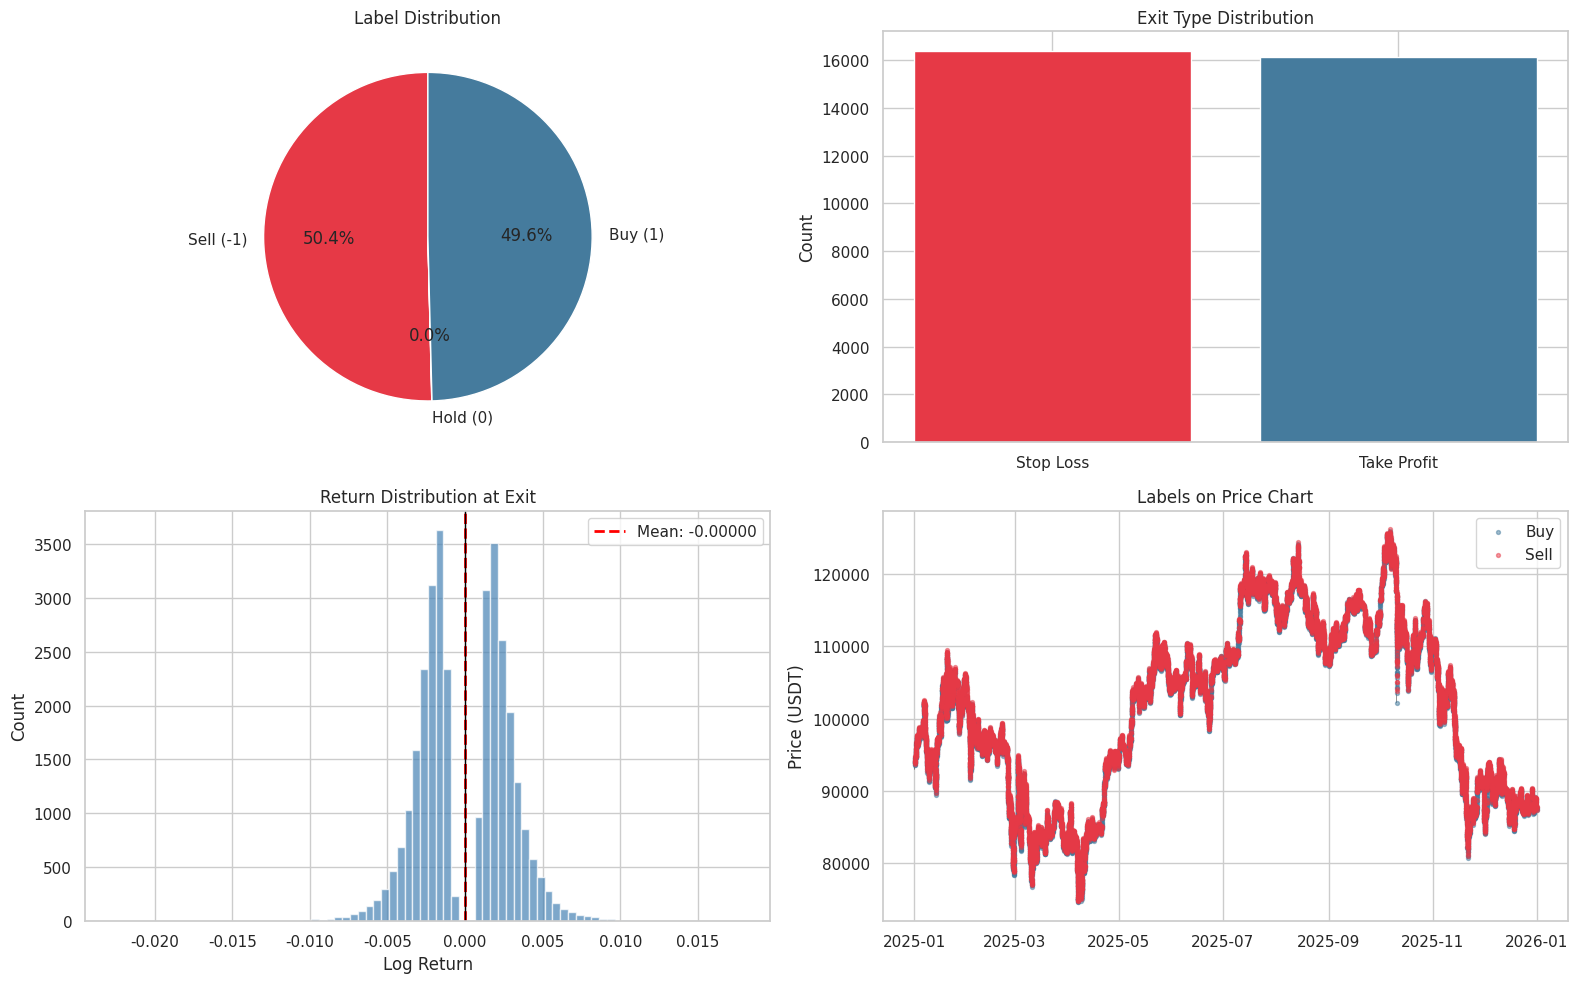

| INFO     | __main__:<module>:61 - Holding period (bars): mean=2.8, median=2.0, max=33


In [16]:
# 6. Visualization Analysis

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# (1) Label Distribution - Pie Chart
label_map = {-1: 'Sell (-1)', 0: 'Hold (0)', 1: 'Buy (1)'}
colors = {-1: '#E63946', 0: '#A8DADC', 1: '#457B9D'}
counts = labeled['label'].value_counts().sort_index()
axes[0, 0].pie(counts.values, 
               labels=[label_map[i] for i in counts.index],
               colors=[colors[i] for i in counts.index],
               autopct='%1.1f%%', startangle=90)
axes[0, 0].set_title("Label Distribution")

# (2) Exit Type Distribution
exit_map = {'pt': 'Take Profit', 'sl': 'Stop Loss', 'vb': 'Vertical Barrier'}
exit_colors = {'pt': '#457B9D', 'sl': '#E63946', 'vb': '#A8DADC'}
exit_counts = labeled['exit_type'].value_counts()
axes[0, 1].bar([exit_map.get(k, k) for k in exit_counts.index], 
               exit_counts.values,
               color=[exit_colors.get(k, 'gray') for k in exit_counts.index])
axes[0, 1].set_title("Exit Type Distribution")
axes[0, 1].set_ylabel("Count")

# (3) Return Distribution
axes[1, 0].hist(labeled['ret'], bins=80, color='steelblue', alpha=0.7, edgecolor='white')
axes[1, 0].axvline(labeled['ret'].mean(), color='red', linestyle='--', linewidth=2, 
                    label=f"Mean: {labeled['ret'].mean():.5f}")
axes[1, 0].axvline(0, color='black', linestyle='-', linewidth=1)
axes[1, 0].set_title("Return Distribution at Exit")
axes[1, 0].set_xlabel("Log Return")
axes[1, 0].set_ylabel("Count")
axes[1, 0].legend()

# (4) Price Chart + Label Annotations
buy_mask = labeled['label'] == 1
sell_mask = labeled['label'] == -1
hold_mask = labeled['label'] == 0

axes[1, 1].plot(df.index, df["close"], linewidth=0.3, color='black', alpha=0.5)
axes[1, 1].scatter(labeled.index[buy_mask], labeled.loc[buy_mask, 'entry_price'], 
                    color='#457B9D', s=8, alpha=0.5, label='Buy', zorder=5)
axes[1, 1].scatter(labeled.index[sell_mask], labeled.loc[sell_mask, 'entry_price'],
                    color='#E63946', s=8, alpha=0.5, label='Sell', zorder=5)
axes[1, 1].set_title("Labels on Price Chart")
axes[1, 1].set_ylabel("Price (USDT)")
axes[1, 1].legend()

plt.tight_layout()
plt.show()

# Holding period statistics (in bars)
holding_bars = []
close_idx = df["close"].index
for t0, row in labeled.iterrows():
    loc0 = _first_loc(close_idx, t0)
    loc1 = _first_loc(close_idx, row['t1'])
    holding_bars.append(loc1 - loc0)
labeled['holding_bars'] = holding_bars

logger.info(f"Holding period (bars): mean={np.mean(holding_bars):.1f}, "
            f"median={np.median(holding_bars):.1f}, max={np.max(holding_bars)}")

### 7. 保存带标签的数据

In [18]:
# 7. Merge labels back into original data and save

# Merge label back to original df (only CUSUM-triggered bars have labels, rest are NaN)
# Use reset_index + merge to handle duplicate timestamps safely
df_labeled = df.reset_index()

labeled_merge = labeled[['label', 'ret', 'exit_type', 't1', 'holding_bars']].copy()
labeled_merge.columns = ['label', 'tb_ret', 'tb_exit_type', 'tb_exit_time', 'tb_holding_bars']
labeled_merge = labeled_merge.reset_index().rename(columns={labeled_merge.index.name or 't0': 'datetime'})
labeled_merge = labeled_merge.drop_duplicates(subset='datetime', keep='first')

df_labeled = df_labeled.merge(labeled_merge, on='datetime', how='left')
df_labeled = df_labeled.set_index('datetime')

# Statistics
labeled_count = df_labeled['label'].notna().sum()
logger.info(f"Original bars: {len(df_labeled)}")
logger.info(f"Labeled bars: {labeled_count} ({labeled_count/len(df_labeled)*100:.1f}%)")

# Save
output_path = project_root / "data" / "preprocess_data" / "factor" / "BTCUSDT" \
    / "BTCUSDT_2025-01-01_2025-12-31_dollar_bars_4m_labeled.csv"
output_path.parent.mkdir(parents=True, exist_ok=True)

df_labeled.to_csv(output_path)
logger.info(f"Saved to: {output_path}")
logger.info(f"File size: {output_path.stat().st_size / 1024 / 1024:.2f} MB")

# Also save the events-only table (for subsequent training)
events_output = project_root / "data" / "preprocess_data" / "factor" / "BTCUSDT" \
    / "BTCUSDT_2025-01-01_2025-12-31_triple_barrier_events.csv"
labeled.to_csv(events_output)
logger.info(f"Events table saved to: {events_output}")

| INFO     | __main__:<module>:17 - Original bars: 82145
| INFO     | __main__:<module>:18 - Labeled bars: 32550 (39.6%)
| INFO     | __main__:<module>:26 - Saved to: e:\B\Economic&Finance\code\CryptoQuant\data\preprocess_data\factor\BTCUSDT\BTCUSDT_2025-01-01_2025-12-31_dollar_bars_4m_labeled.csv
| INFO     | __main__:<module>:27 - File size: 14.50 MB
| INFO     | __main__:<module>:33 - Events table saved to: e:\B\Economic&Finance\code\CryptoQuant\data\preprocess_data\factor\BTCUSDT\BTCUSDT_2025-01-01_2025-12-31_triple_barrier_events.csv
